## Fitting Sigmoid to empirical NN
### Manually selecting bin size

In [1]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT,CE

In [5]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
data_locations = [r"D:\file\Research\P-value\data\AT"+c for c in classes]
data_locations_CE = [r"D:\file\Research\P-value\data\CE"+c for c in classes]

In [6]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

In [7]:
df_comb = combine_data(data_locations,classes)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

In [8]:
df_CE = combine_data(data_locations_CE,classes)
df_class_CE = df_CE['class']
df_CE = df_CE.drop("class", axis = 1)
df_CE = pd.DataFrame(MinMaxScaler().fit_transform(df_CE))
df_CE['class'] = df_class_CE.reset_index(drop = True)

In [9]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [10]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data,title):
    '''
    return x,y data of CDF 
    '''    
    sort_data = np.sort(data)
    #print("data len: ",len(sort_data))
    x = np.concatenate(([0],sort_data))
    #print("x len : ",len(x))
    #print("first: ", x[0], "\nlast: ",x[-1])
    
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    
    return x,y


# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func,s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt


# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning=False):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 7:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
            elif i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        y2 = func_list[i](x/factor, *p)
        ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()

### Sigmoid functions

In [34]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): 
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return m

def GD(x, x0, k):
    m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return m

def ERF(x, x0, k):
    m = (1+erf(k*(x-x0)))/2
    return m

def algebra(x, x0, k):
    m = (1+x/((1+abs(x)**k)**(1/k)))/2
    return m

def arctan_GD(x,x0,k, w):
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

### Fitting on All points without binning

In [21]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
factors = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
colors = ['g','r','c','m','y','k','brown','gray']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

For  ER  :
curve_fit parameter on  logistic :  [5.01019699 0.63931604]
curve_fit parameter on  tanh :  [5.01019521 0.31965852]
curve_fit parameter on  arctan :  [4.9315695  0.66176824]
curve_fit parameter on  GD :  [4.99858203 0.26140507]
curve_fit parameter on  ERF :  [5.02452782 0.27073493]
curve_fit parameter on  algebra :  [4.74320923 0.24683585]
curve_fit parameter on  arctan_GD :  [ 4.96754038  1.173988   -0.60411277]
curve_fit parameter on  Gompertz :  [1.75786268 0.43324337]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


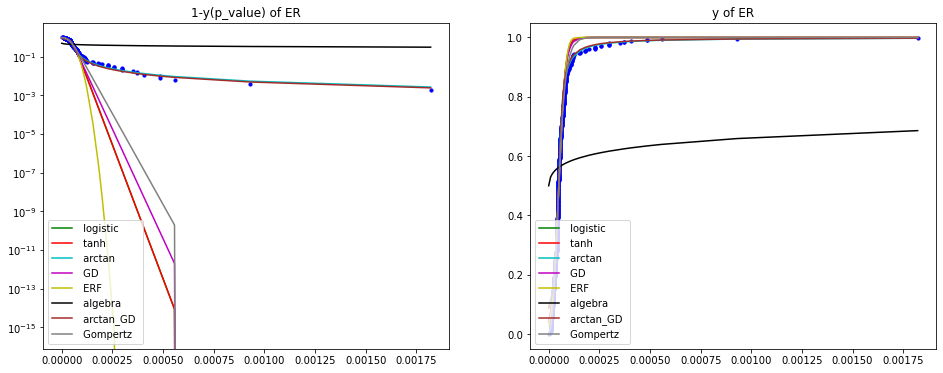

For  ERDD  :
curve_fit parameter on  logistic :  [1.05927601 2.72239646]
curve_fit parameter on  tanh :  [1.05927603 1.36119758]
curve_fit parameter on  arctan :  [1.04166089 2.69013301]
curve_fit parameter on  GD :  [1.05639975 1.10582799]
curve_fit parameter on  ERF :  [1.06344078 1.16179339]
curve_fit parameter on  algebra :  [1.01217827 0.36077615]
curve_fit parameter on  arctan_GD :  [1.05411789 1.187677   0.90007104]
curve_fit parameter on  Gompertz :  [1.58329448 1.90085267]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


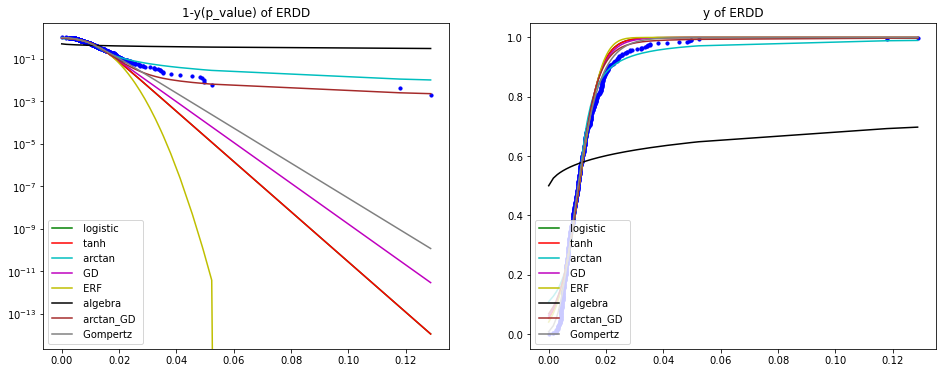

For  GEO  :
curve_fit parameter on  logistic :  [2.23131802 1.45325018]
curve_fit parameter on  tanh :  [2.23131428 0.72663001]
curve_fit parameter on  arctan :  [2.18763034 1.43353787]
curve_fit parameter on  GD :  [2.22536583 0.58884726]
curve_fit parameter on  ERF :  [2.23897623 0.62255387]
curve_fit parameter on  algebra :  [2.07712928 0.27920832]
curve_fit parameter on  arctan_GD :  [2.21017483 0.73690297 0.70316769]
curve_fit parameter on  Gompertz :  [1.83358288 1.01109907]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


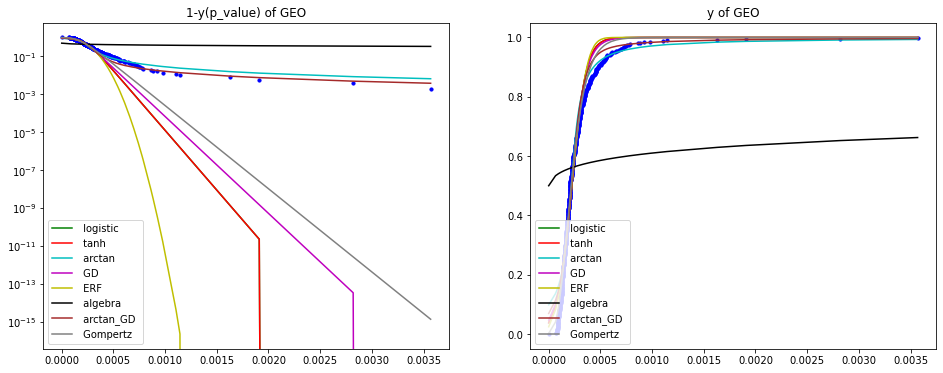

For  GEOGD  :
curve_fit parameter on  logistic :  [0.41592654 4.80376309]
curve_fit parameter on  tanh :  [0.41592611 2.40188789]
curve_fit parameter on  arctan :  [0.39851997 4.58004858]
curve_fit parameter on  GD :  [0.41366408 1.9344383 ]
curve_fit parameter on  ERF :  [0.41895869 2.07007359]
curve_fit parameter on  algebra :  [0.35420422 0.66767855]
curve_fit parameter on  arctan_GD :  [0.39927522 3.84098601 0.17554037]
curve_fit parameter on  Gompertz :  [0.99437282 3.39693702]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


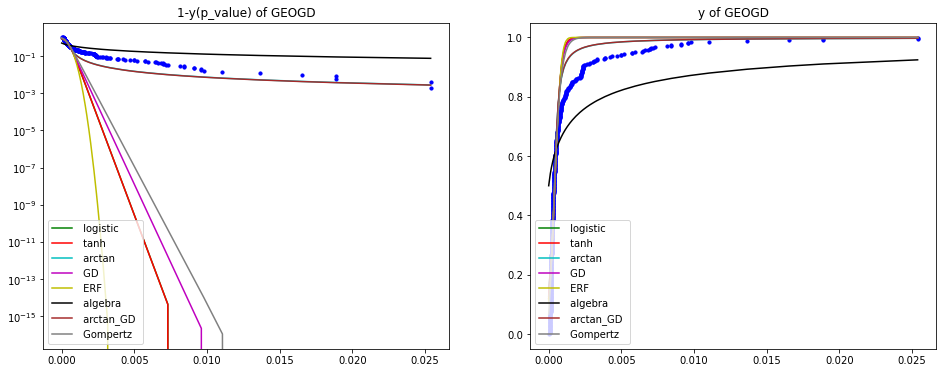

For  HGG  :
curve_fit parameter on  logistic :  [9.8439015  0.25848108]
curve_fit parameter on  tanh :  [9.84394079 0.12923882]
curve_fit parameter on  arctan :  [9.46561202 0.26217161]
curve_fit parameter on  GD :  [9.7885904  0.10504069]
curve_fit parameter on  ERF :  [9.92224306 0.11001518]
curve_fit parameter on  algebra :  [8.94144704 0.22188734]
curve_fit parameter on  arctan_GD :  [ 9.70014547  0.66168816 -1.12816861]
curve_fit parameter on  Gompertz :  [1.38823933 0.18390258]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


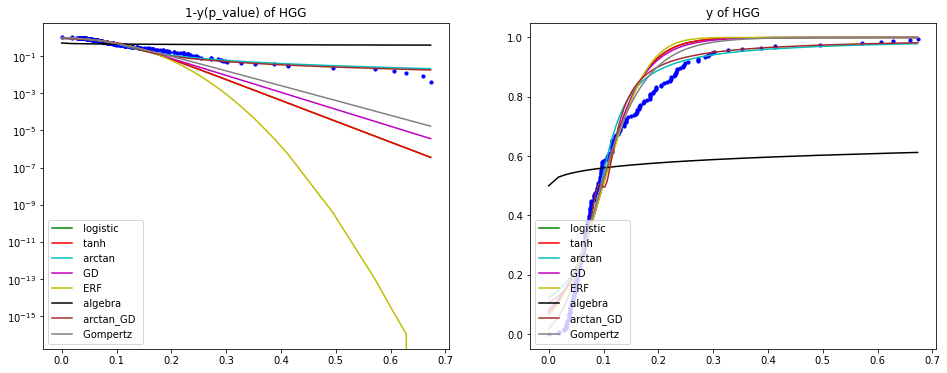

For  SF  :
curve_fit parameter on  logistic :  [2.91621671 1.54410037]
curve_fit parameter on  tanh :  [2.91621514 0.77205075]
curve_fit parameter on  arctan :  [2.88233441 1.52801738]
curve_fit parameter on  GD :  [2.91107066 0.62702766]
curve_fit parameter on  ERF :  [2.92303736 0.65946336]
curve_fit parameter on  algebra :  [2.82972287 0.23538203]
curve_fit parameter on  arctan_GD :  [2.90997015 0.63945519 0.97189539]
curve_fit parameter on  Gompertz :  [2.72942207 1.08312589]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


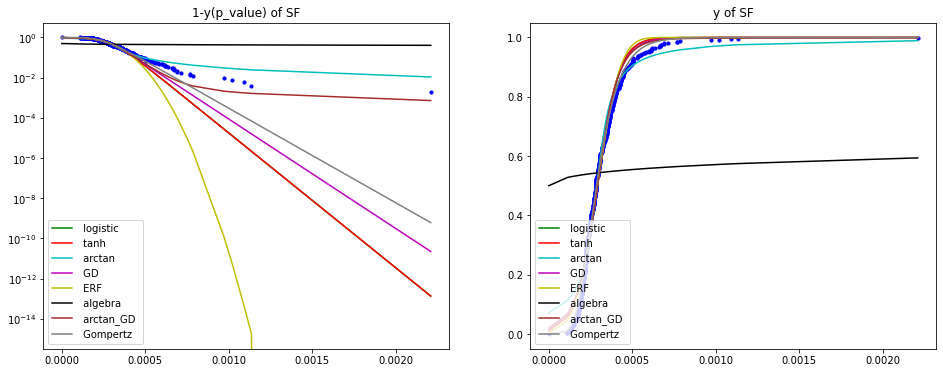

For  SFDD  :
curve_fit parameter on  logistic :  [1.6739215  1.76134158]
curve_fit parameter on  tanh :  [1.67391232 0.88068919]
curve_fit parameter on  arctan :  [1.62544171 1.77613981]
curve_fit parameter on  GD :  [1.66648145 0.71660845]
curve_fit parameter on  ERF :  [1.68414598 0.74923596]
curve_fit parameter on  algebra :  [1.55198565 0.31595582]
curve_fit parameter on  arctan_GD :  [ 1.65649778  3.96163708 -0.92405749]
curve_fit parameter on  Gompertz :  [1.64090647 1.22864676]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


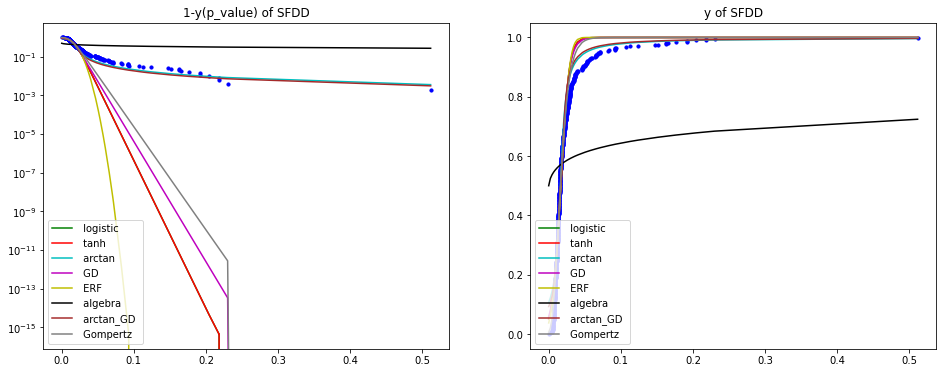

For  Sticky  :
curve_fit parameter on  logistic :  [5.72785809 0.94982721]
curve_fit parameter on  tanh :  [5.72786237 0.47491125]
curve_fit parameter on  arctan :  [5.66467309 0.94527715]
curve_fit parameter on  GD :  [5.7185246  0.38590835]
curve_fit parameter on  ERF :  [5.73990646 0.4054232 ]
curve_fit parameter on  algebra :  [5.49479545 0.19825999]
curve_fit parameter on  arctan_GD :  [5.71498191 0.39985065 0.95002077]
curve_fit parameter on  Gompertz :  [3.39558209 0.6675235 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


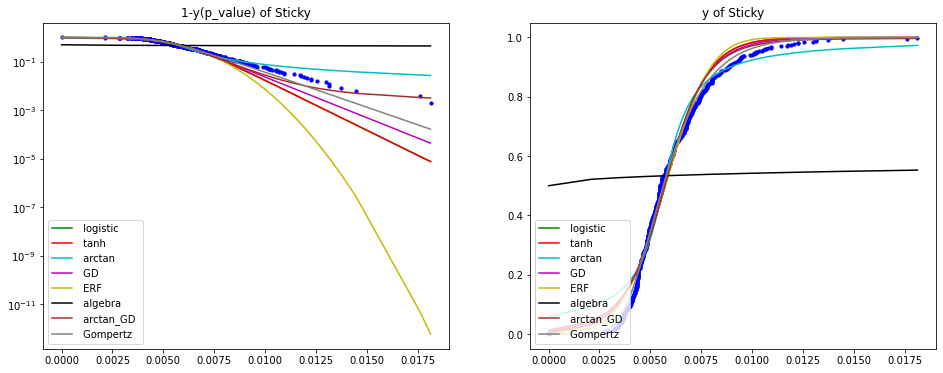

In [33]:
# AT
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors)

In [35]:
factors_CE = [1e-4, 1e-2, 1e-3, 1e-2,1e-1, 1e-4, 1e-1, 1e-4]

For  ER  :
curve_fit parameter on  logistic :  [1.94606213 1.81560264]
curve_fit parameter on  tanh :  [1.94606109 0.90780356]
curve_fit parameter on  arctan :  [1.92554653 1.84634992]
curve_fit parameter on  GD :  [1.94274263 0.74108489]
curve_fit parameter on  ERF :  [1.95088804 0.76944669]
curve_fit parameter on  algebra :  [1.8709861  0.28815412]
curve_fit parameter on  arctan_GD :  [1.93702551 0.87978063 0.7766376 ]
curve_fit parameter on  Gompertz :  [1.98391685 1.23381394]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


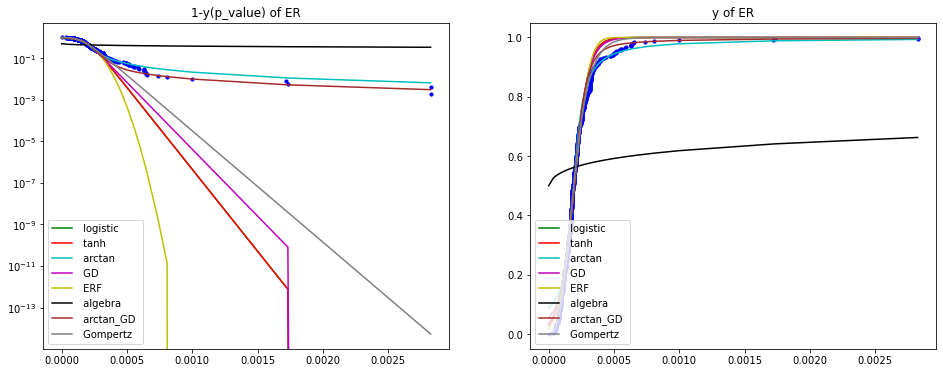

For  ERDD  :
curve_fit parameter on  logistic :  [1.12616432 3.99340048]
curve_fit parameter on  tanh :  [1.12616442 1.99669952]
curve_fit parameter on  arctan :  [1.11156876 3.96434666]
curve_fit parameter on  GD :  [1.12404433 1.62186182]
curve_fit parameter on  ERF :  [1.12902684 1.7038601 ]
curve_fit parameter on  algebra :  [1.08467194 0.30205569]
curve_fit parameter on  arctan_GD :  [1.1195791  1.97094562 0.74217289]
curve_fit parameter on  Gompertz :  [2.69934083 2.76997435]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


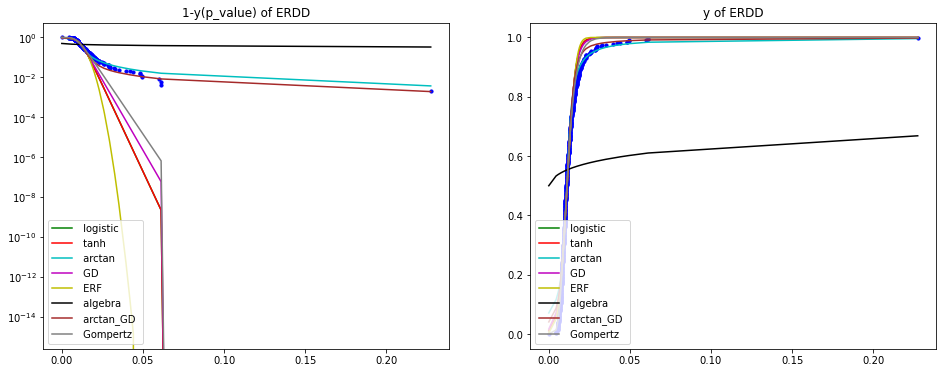

For  GEO  :
curve_fit parameter on  logistic :  [1.67382321 2.78055501]
curve_fit parameter on  tanh :  [1.67382322 1.39027732]
curve_fit parameter on  arctan :  [1.66044839 2.74387975]
curve_fit parameter on  GD :  [1.67203869 1.12859645]
curve_fit parameter on  ERF :  [1.67617152 1.18746551]
curve_fit parameter on  algebra :  [1.6242431  0.26798898]
curve_fit parameter on  arctan_GD :  [1.67051126 1.21253376 0.8994181 ]
curve_fit parameter on  Gompertz :  [2.78536019 1.91606474]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


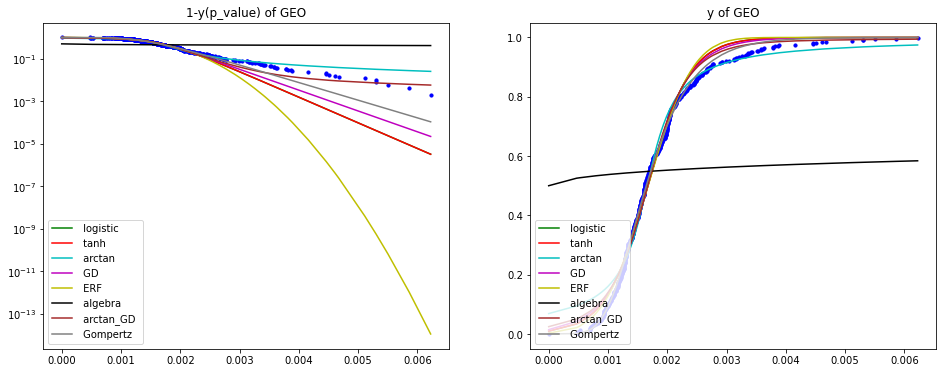

For  GEOGD  :
curve_fit parameter on  logistic :  [0.29490803 7.75814042]
curve_fit parameter on  tanh :  [0.29490921 3.87902334]
curve_fit parameter on  arctan :  [0.27843769 7.90380023]
curve_fit parameter on  GD :  [0.29283136 3.14207303]
curve_fit parameter on  ERF :  [0.29773893 3.31491548]
curve_fit parameter on  algebra :  [0.24724461 3.04096133]
curve_fit parameter on  arctan_GD :  [ 0.29506843 22.09716848 -1.4045109 ]
curve_fit parameter on  Gompertz :  [1.23844122 5.64889883]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


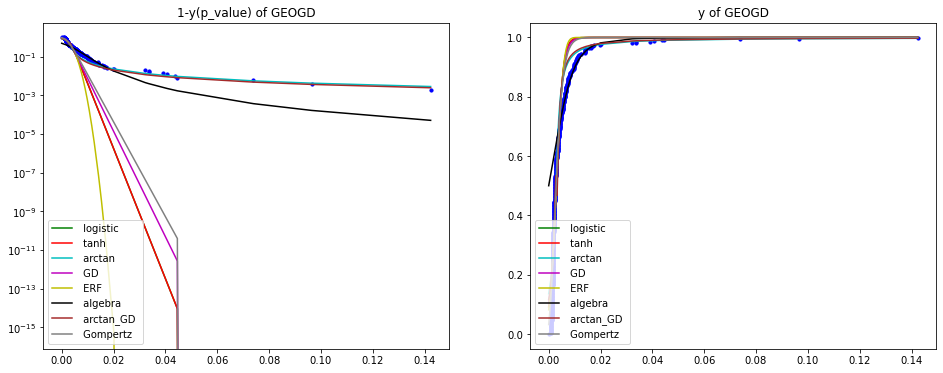

For  HGG  :
curve_fit parameter on  logistic :  [0.49047975 4.53901087]
curve_fit parameter on  tanh :  [0.49048164 2.26947972]
curve_fit parameter on  arctan :  [0.45946001 4.66386372]
curve_fit parameter on  GD :  [0.4867633  1.83754941]
curve_fit parameter on  ERF :  [0.49551134 1.93985614]
curve_fit parameter on  algebra :  [0.40294287 0.57946243]
curve_fit parameter on  arctan_GD :  [0.46070551 3.94516354 0.16414252]
curve_fit parameter on  Gompertz :  [1.20607326 3.33476332]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


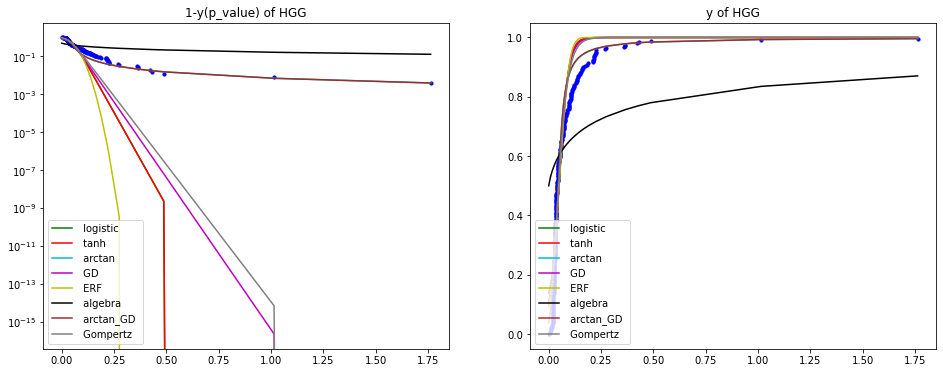

For  SF  :
curve_fit parameter on  logistic :  [9.44660321 0.55979228]
curve_fit parameter on  tanh :  [9.4466019  0.27989618]
curve_fit parameter on  arctan :  [9.36503726 0.55993844]
curve_fit parameter on  GD :  [9.43518287 0.22765541]
curve_fit parameter on  ERF :  [9.46118399 0.23842467]
curve_fit parameter on  algebra :  [9.20819632 0.19056114]
curve_fit parameter on  arctan_GD :  [ 9.42293395  1.19555264 -0.84402286]
curve_fit parameter on  Gompertz :  [3.21352999 0.38419889]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


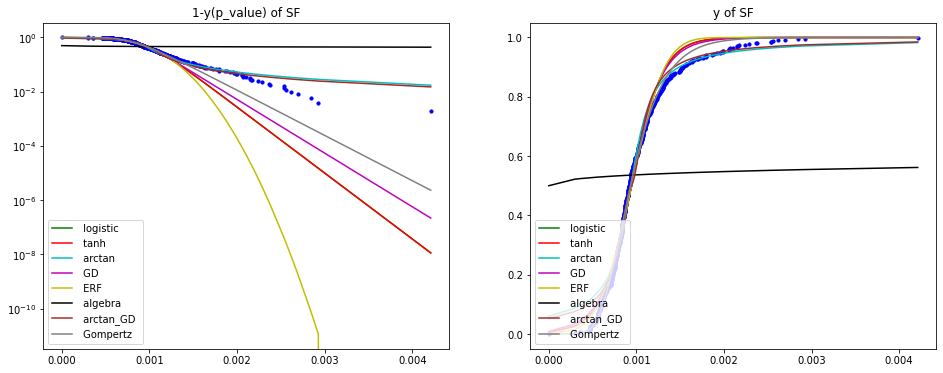

For  SFDD  :
curve_fit parameter on  logistic :  [ 0.23673612 11.65286499]
curve_fit parameter on  tanh :  [0.23673607 5.8264371 ]
curve_fit parameter on  arctan :  [ 0.22901712 11.6447054 ]
curve_fit parameter on  GD :  [0.23560146 4.72482547]
curve_fit parameter on  ERF :  [0.23841346 4.96935401]
curve_fit parameter on  algebra :  [ 0.21892582 10.78660079]
curve_fit parameter on  arctan_GD :  [0.22954376 8.86509579 0.27276383]
curve_fit parameter on  Gompertz :  [1.52828905 8.21670885]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


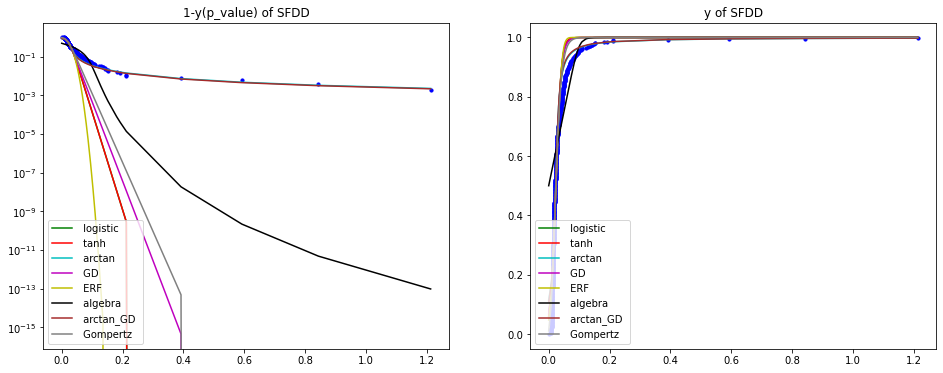

For  Sticky  :
curve_fit parameter on  logistic :  [7.99465705e+01 7.55061503e-02]
curve_fit parameter on  tanh :  [7.99465658e+01 3.77530566e-02]
curve_fit parameter on  arctan :  [7.95860654e+01 7.49588673e-02]
curve_fit parameter on  GD :  [7.98959136e+01 3.06980529e-02]
curve_fit parameter on  ERF :  [8.00128222e+01 3.21993518e-02]
curve_fit parameter on  algebra :  [78.50832208  0.1433607 ]
curve_fit parameter on  arctan_GD :  [79.76383095  0.1584869  -0.8358784 ]
curve_fit parameter on  Gompertz :  [2.11976164 1.        ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


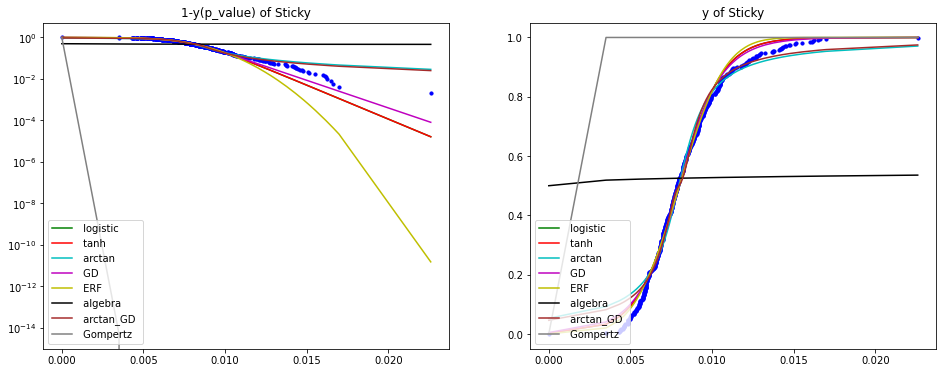

In [37]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors_CE[i], functions, colors)

### Binning

In [69]:
# binning first, add (0,0) at the front later when calculate y

def data_binning(data):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        binned_data.append(np.mean(x[i:i+count]))
        i += count
    
    return binned_data


def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y
 

#### AT

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [5.07797398 0.59115369]
curve_fit parameter on  tanh :  [5.07796948 0.29557785]
curve_fit parameter on  arctan :  [4.99318686 0.60992837]
curve_fit parameter on  GD :  [5.06607858 0.24153901]
curve_fit parameter on  ERF :  [5.09204204 0.25064859]
curve_fit parameter on  algebra :  [4.74320923 0.24428437]
curve_fit parameter on  arctan_GD :  [ 5.04102127  1.1190459  -0.64914887]
curve_fit parameter on  Gompertz :  [1.60688364 0.39740493]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


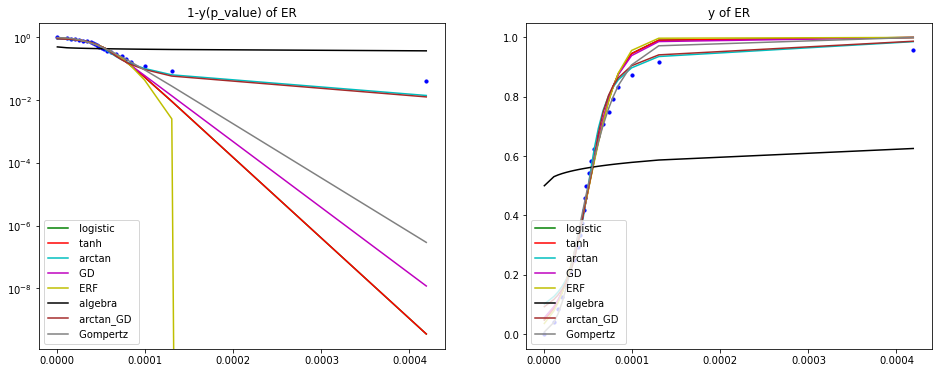

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.07512038 2.53863779]
curve_fit parameter on  tanh :  [1.07512033 1.26931841]
curve_fit parameter on  arctan :  [1.05559788 2.51593788]
curve_fit parameter on  GD :  [1.07188823 1.03250419]
curve_fit parameter on  ERF :  [1.07969008 1.08162588]
curve_fit parameter on  algebra :  [1.01217827 0.35372926]
curve_fit parameter on  arctan_GD :  [1.07007499 1.08833565 0.92572509]
curve_fit parameter on  Gompertz :  [1.46803305 1.76338188]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


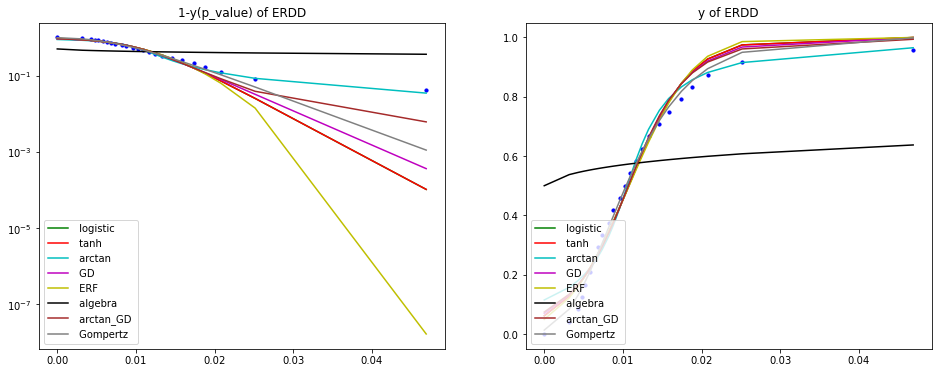

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [2.26613235 1.33951129]
curve_fit parameter on  tanh :  [2.26612946 0.66975909]
curve_fit parameter on  arctan :  [2.21920906 1.32532057]
curve_fit parameter on  GD :  [2.2596074  0.54340802]
curve_fit parameter on  ERF :  [2.27449656 0.57284214]
curve_fit parameter on  algebra :  [2.07712928 0.27606388]
curve_fit parameter on  arctan_GD :  [2.244768   0.66605842 0.72993856]
curve_fit parameter on  Gompertz :  [1.68669987 0.9294231 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


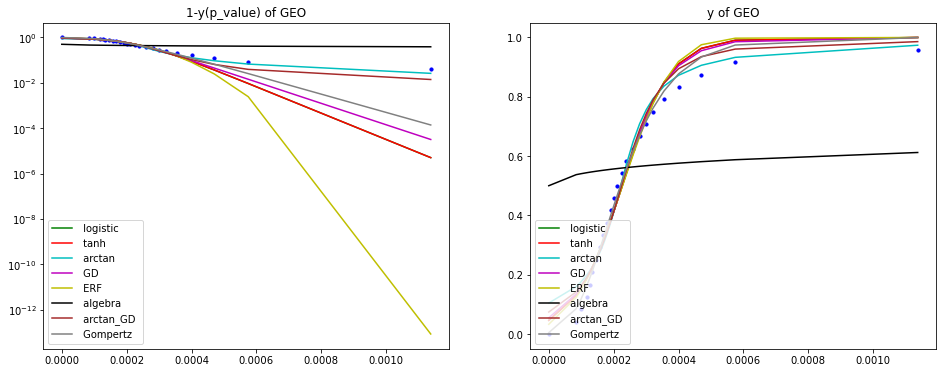

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [0.42812433 4.533013  ]
curve_fit parameter on  tanh :  [0.42812349 2.26651672]
curve_fit parameter on  arctan :  [0.40922295 4.32666737]
curve_fit parameter on  GD :  [0.42569694 1.82663962]
curve_fit parameter on  ERF :  [0.43140924 1.95184289]
curve_fit parameter on  algebra :  [0.35420422 0.62215232]
curve_fit parameter on  arctan_GD :  [0.41069824 3.40099086 0.24135329]
curve_fit parameter on  Gompertz :  [0.93631761 3.15798872]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


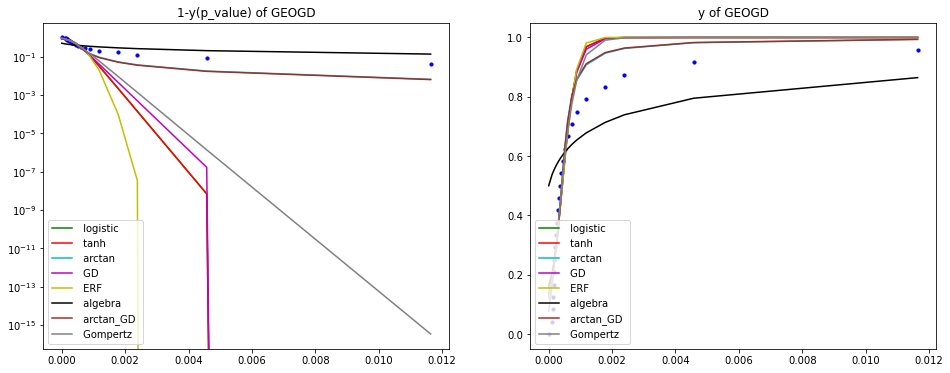

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [10.20956289  0.229996  ]
curve_fit parameter on  tanh :  [10.20960343  0.11499672]
curve_fit parameter on  arctan :  [9.7574221  0.23562532]
curve_fit parameter on  GD :  [10.13871432  0.09382883]
curve_fit parameter on  ERF :  [10.31128284  0.09734595]
curve_fit parameter on  algebra :  [8.94144704 0.21813791]
curve_fit parameter on  arctan_GD :  [ 9.91023035  0.55689289 -1.00435192]
curve_fit parameter on  Gompertz :  [1.23253636 0.1620233 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


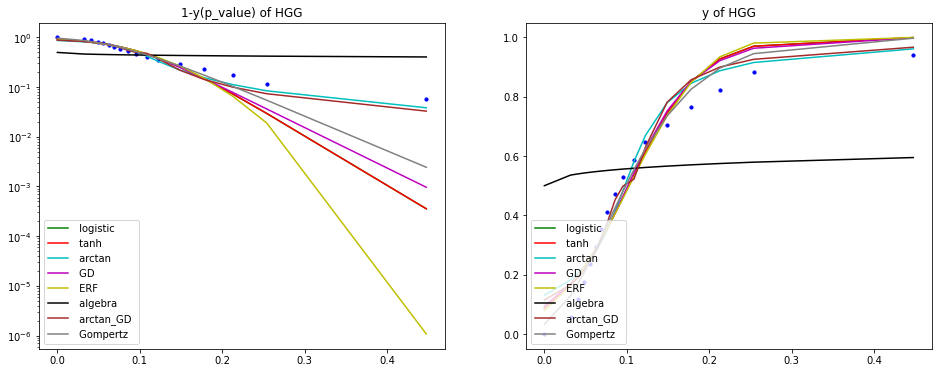

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [2.94451734 1.42403876]
curve_fit parameter on  tanh :  [2.94451701 0.71201998]
curve_fit parameter on  arctan :  [2.90944193 1.40479058]
curve_fit parameter on  GD :  [2.93918755 0.57791483]
curve_fit parameter on  ERF :  [2.95158669 0.60839849]
curve_fit parameter on  algebra :  [2.82972287 0.23294768]
curve_fit parameter on  arctan_GD :  [2.93596461 0.61251131 0.91761018]
curve_fit parameter on  Gompertz :  [2.52030312 1.00044091]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


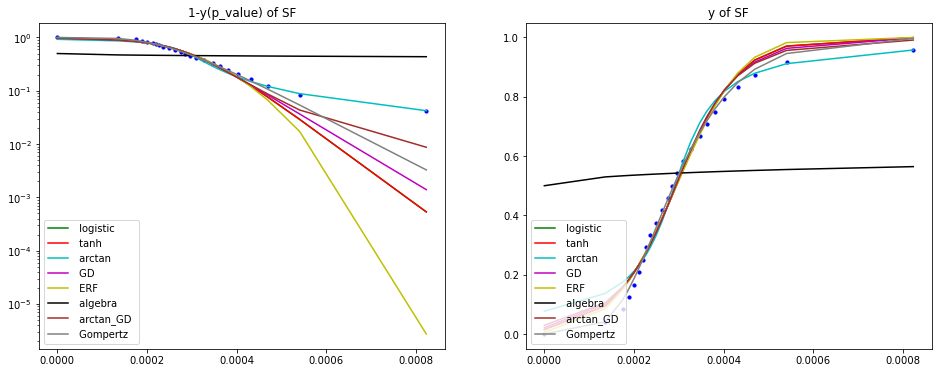

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [1.70428983 1.61822203]
curve_fit parameter on  tanh :  [1.70428487 0.80911912]
curve_fit parameter on  arctan :  [1.65056355 1.63632572]
curve_fit parameter on  GD :  [1.69621794 0.65862933]
curve_fit parameter on  ERF :  [1.7147492  0.68895094]
curve_fit parameter on  algebra :  [1.55198565 0.31085823]
curve_fit parameter on  arctan_GD :  [1.66479037 1.01722504 0.47517044]
curve_fit parameter on  Gompertz :  [1.49559298 1.11968089]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


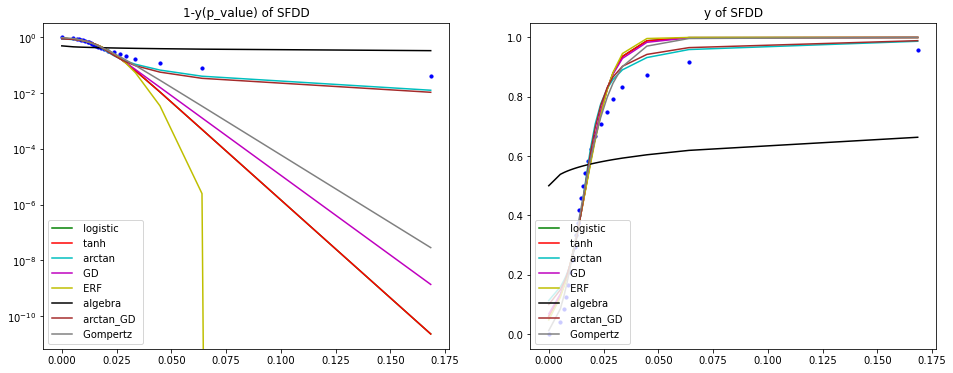

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [5.77496183 0.87224034]
curve_fit parameter on  tanh :  [5.77496269 0.43611979]
curve_fit parameter on  arctan :  [5.71007098 0.86372475]
curve_fit parameter on  GD :  [5.76554603 0.35385547]
curve_fit parameter on  ERF :  [5.78707774 0.37286559]
curve_fit parameter on  algebra :  [5.49479545 0.19621065]
curve_fit parameter on  arctan_GD :  [5.75745789 0.38391713 0.88647097]
curve_fit parameter on  Gompertz :  [3.1220332  0.61408322]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


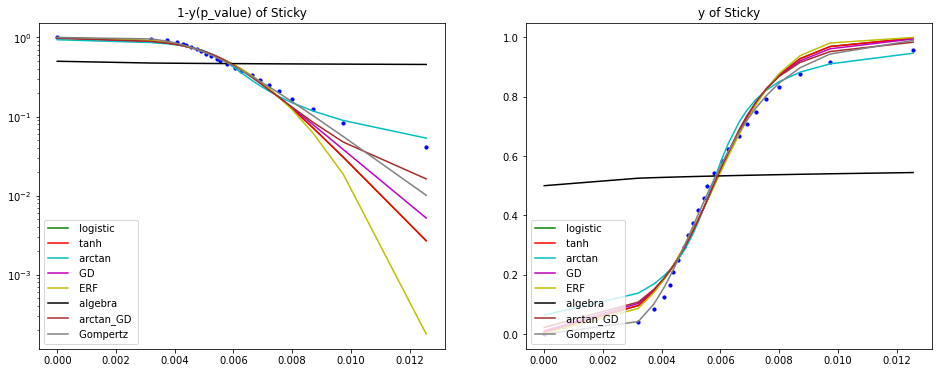

In [70]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

#### CE

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ER  :
curve_fit parameter on  logistic :  [19.67974268  0.16737684]
curve_fit parameter on  tanh :  [19.67973911  0.08368848]
curve_fit parameter on  arctan :  [19.44032271  0.17071112]
curve_fit parameter on  GD :  [19.64117604  0.06834422]
curve_fit parameter on  ERF :  [19.73146082  0.07098059]
curve_fit parameter on  algebra :  [18.70986096  0.19060088]
curve_fit parameter on  arctan_GD :  [19.58060229  0.08023494  0.79057039]
curve_fit parameter on  Gompertz :  [1.82153756 0.11364527]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


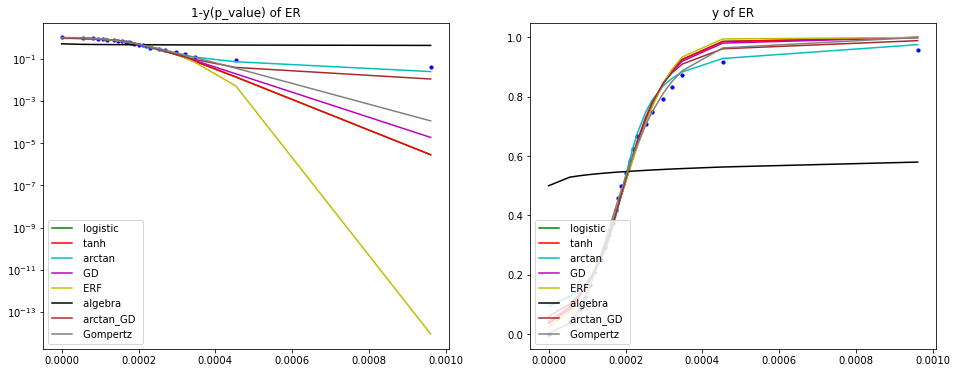

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21]
For  ERDD  :
curve_fit parameter on  logistic :  [1.13746416 3.65241728]
curve_fit parameter on  tanh :  [1.13746436 1.82620707]
curve_fit parameter on  arctan :  [1.12137361 3.63648897]
curve_fit parameter on  GD :  [1.13507385 1.48355731]
curve_fit parameter on  ERF :  [1.14063739 1.55858245]
curve_fit parameter on  algebra :  [1.08467194 0.29971512]
curve_fit parameter on  arctan_GD :  [ 1.1314702   8.24133632 -0.92805654]
curve_fit parameter on  Gompertz :  [2.47720747 2.54474602]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


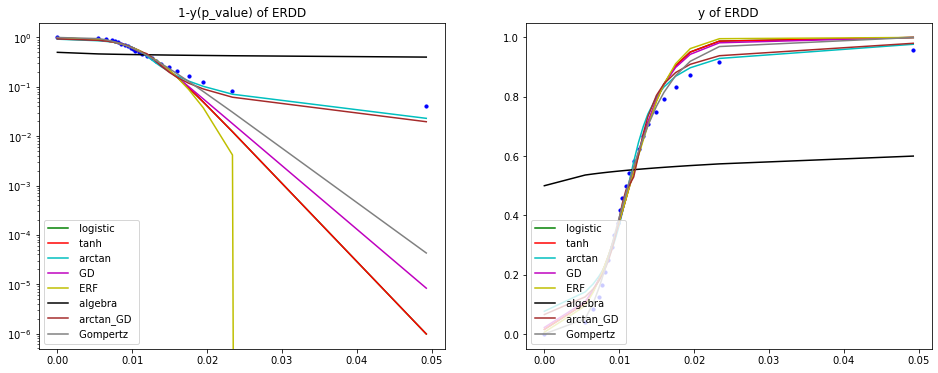

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  GEO  :
curve_fit parameter on  logistic :  [16.88124302  0.25628351]
curve_fit parameter on  tanh :  [16.88124501  0.12814173]
curve_fit parameter on  arctan :  [16.74470262  0.25281827]
curve_fit parameter on  GD :  [16.86262886  0.10398031]
curve_fit parameter on  ERF :  [16.90592968  0.10948613]
curve_fit parameter on  algebra :  [16.24243101  0.17940941]
curve_fit parameter on  arctan_GD :  [16.87418064  0.55172886 -0.87807211]
curve_fit parameter on  Gompertz :  [2.56485766 0.1766948 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:32: RuntimeWarning: overflow encountered in power
  m = np.e**(-np.e**(b-c*x))


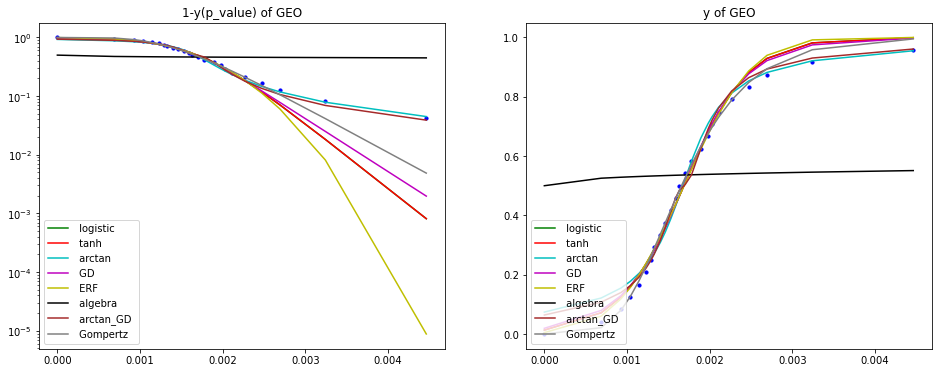

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
For  GEOGD  :
curve_fit parameter on  logistic :  [3.03730585 0.7219329 ]
curve_fit parameter on  tanh :  [3.03734551 0.36095358]
curve_fit parameter on  arctan :  [2.86385915 0.73563421]
curve_fit parameter on  GD :  [3.01458182 0.29293635]
curve_fit parameter on  ERF :  [3.06808891 0.30794802]
curve_fit parameter on  algebra :  [2.47244613 0.28165942]
curve_fit parameter on  arctan_GD :  [ 3.03527655  2.06072871 -1.40539688]
curve_fit parameter on  Gompertz :  [1.14393898 0.51568285]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


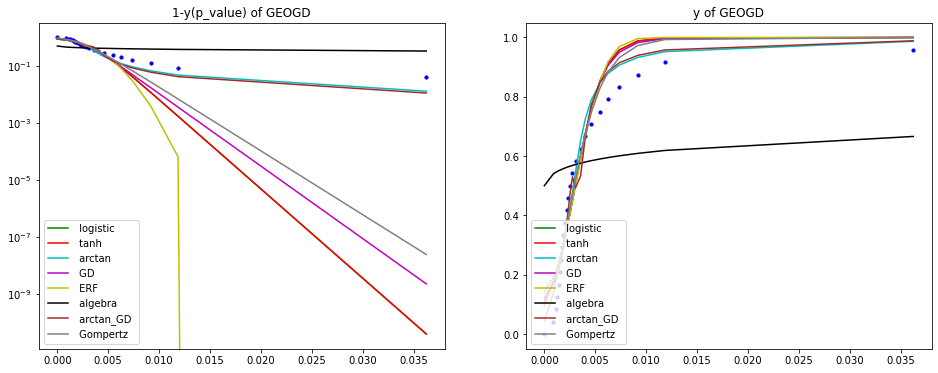

items in each bin:  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15]
For  HGG  :
curve_fit parameter on  logistic :  [5.14559326 0.40368373]
curve_fit parameter on  tanh :  [5.14558677 0.2018425 ]
curve_fit parameter on  arctan :  [4.80252394 0.41307615]
curve_fit parameter on  GD :  [5.10262578 0.16373985]
curve_fit parameter on  ERF :  [5.20231142 0.17236596]
curve_fit parameter on  algebra :  [4.02942869 0.25351051]
curve_fit parameter on  arctan_GD :  [ 5.31104001  1.51273211 -2.16841937]
curve_fit parameter on  Gompertz :  [1.06478672 0.28954134]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


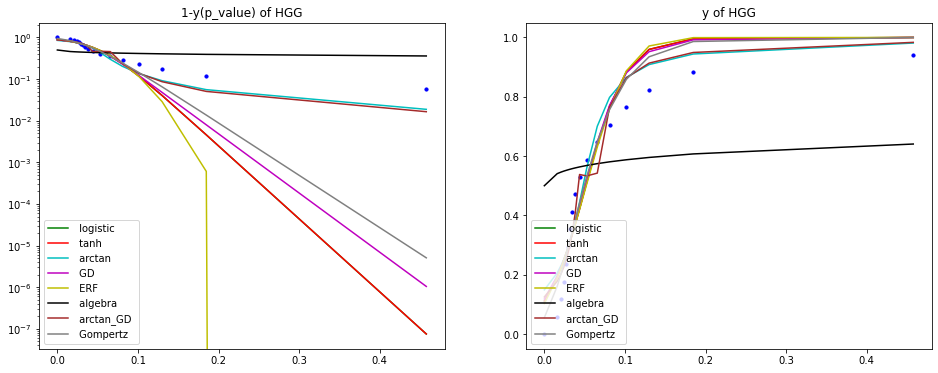

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  SF  :
curve_fit parameter on  logistic :  [9.52245516 0.51248981]
curve_fit parameter on  tanh :  [9.52245395 0.25624497]
curve_fit parameter on  arctan :  [9.43662909 0.5117897 ]
curve_fit parameter on  GD :  [9.51053361 0.2081854 ]
curve_fit parameter on  ERF :  [9.53743344 0.2186391 ]
curve_fit parameter on  algebra :  [9.20819632 0.18869462]
curve_fit parameter on  arctan_GD :  [ 9.49599293  1.0870769  -0.82860722]
curve_fit parameter on  Gompertz :  [2.94047753 0.3521497 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


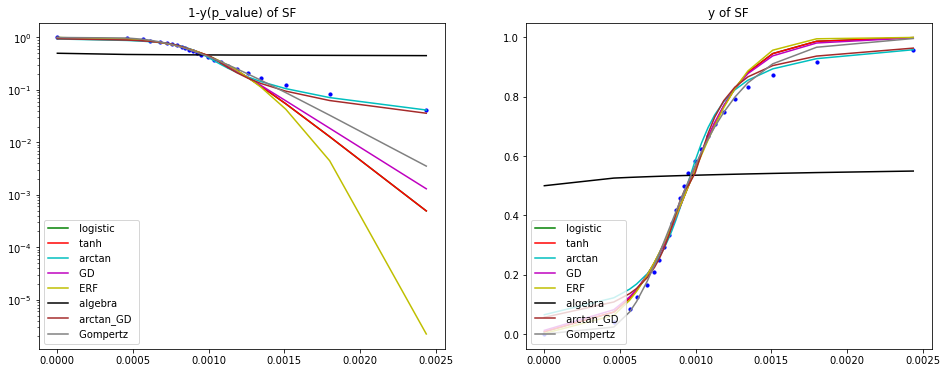

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21]
For  SFDD  :
curve_fit parameter on  logistic :  [2.41783943 1.06377599]
curve_fit parameter on  tanh :  [2.41783476 0.53189142]
curve_fit parameter on  arctan :  [2.32341499 1.08321449]
curve_fit parameter on  GD :  [2.40320202 0.43307304]
curve_fit parameter on  ERF :  [2.43897373 0.45138858]
curve_fit parameter on  algebra :  [2.18925823 0.28540336]
curve_fit parameter on  arctan_GD :  [2.33228759 0.78940948 0.31492124]
curve_fit parameter on  Gompertz :  [1.38934934 0.7458292 ]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


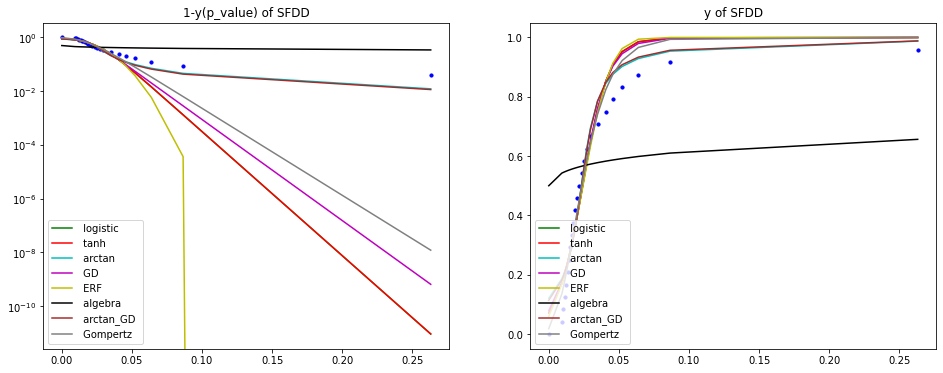

items in each bin:  [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21]
For  Sticky  :
curve_fit parameter on  logistic :  [8.04471967 0.6968473 ]
curve_fit parameter on  tanh :  [8.04471947 0.3484237 ]
curve_fit parameter on  arctan :  [8.00698699 0.68904584]
curve_fit parameter on  GD :  [8.03948343 0.28286389]
curve_fit parameter on  ERF :  [8.05156108 0.29770447]
curve_fit parameter on  algebra :  [7.85083221 0.18322561]
curve_fit parameter on  arctan_GD :  [8.03606495 0.29850525 0.92413823]
curve_fit parameter on  Gompertz :  [3.42949201 0.47877474]


C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
C:\Users\SHIQIJ~1\AppData\Local\Temp/ipykernel_7264/2234094234.py:24: RuntimeWarning: invalid value encountered in true_divide
  m = (1+(x/((1+abs(x)**k)**(1/k))))/2
D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


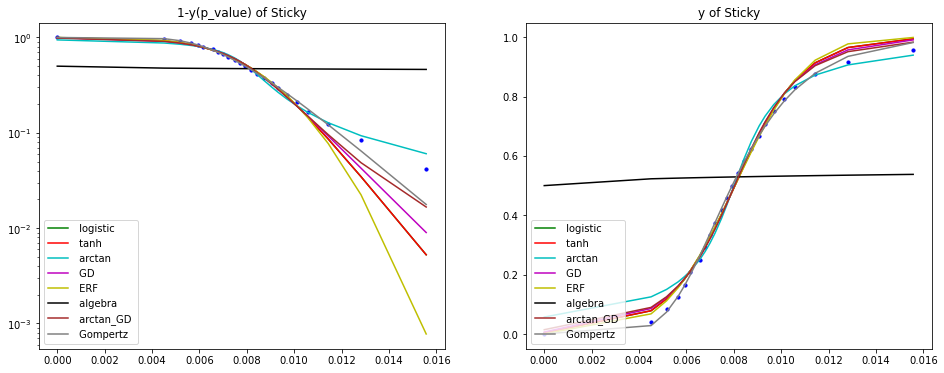

In [71]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

In [3]:
print(np.linspace(0,500,501))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [4]:
print(np.arange(500))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [2]:
def histedges_equalN(x, nbin):
  npt = len(x)
  return np.interp(np.linspace(0, npt, nbin + 1),
                    np.arange(npt),
                    np.sort(x))

In [12]:
er = data_distance(data(df_comb,'ER'))

In [13]:
print(len(er))

499


In [14]:
histedges_equalN(er,22)

array([8.25909560e-06, 1.28955053e-05, 1.81457784e-05, 2.28378924e-05,
       2.76927290e-05, 3.23742730e-05, 3.79834526e-05, 4.00965134e-05,
       4.21668313e-05, 4.44295978e-05, 4.57246315e-05, 4.74629349e-05,
       4.96095398e-05, 5.34660014e-05, 5.67886738e-05, 6.17428213e-05,
       6.65249440e-05, 7.29852525e-05, 7.90310583e-05, 8.63020797e-05,
       1.11521853e-04, 1.80600389e-04, 1.82082670e-03])